# 异源图像变化检测

[TOC]

In [38]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os

## 数据集

`SZTAKI`数据集一共有 `13` 幅图片, 图片为 952x640x3 (W,H,C). 

    - `Tiszadob` : `5` 幅图片
    
    - `Szada` : `7` 幅图片
    
    - `Archieve` : `1` 幅图片
    

包含有5种变化：  

    - new built-up regions   
    
    - building operations   
    
    - planting of large group of trees   
    
    - fresh plough-land   
    
    - groundwork before building over  



### 所有图片展示

In [66]:
im1s = []
im2s = []
gts = []

for root,folder,files in os.walk('datasets/source/SZTAKI_AirChange_Benchmark/'):
    for file in files:
        if file[:3]=='im1':
            im1s.append(root+'/'+file)
        elif file[:3]=='im2':
            im2s.append(root+'/'+file)
        else:
            gts.append(root+'/'+file)
print('\n'.join(im1s))

datasets/source/SZTAKI_AirChange_Benchmark/Archieve/im1.bmp
datasets/source/SZTAKI_AirChange_Benchmark/Szada\1/im1.bmp
datasets/source/SZTAKI_AirChange_Benchmark/Szada\2/im1.bmp
datasets/source/SZTAKI_AirChange_Benchmark/Szada\3/im1.bmp
datasets/source/SZTAKI_AirChange_Benchmark/Szada\4/im1.bmp
datasets/source/SZTAKI_AirChange_Benchmark/Szada\5/im1.bmp
datasets/source/SZTAKI_AirChange_Benchmark/Szada\6/im1.bmp
datasets/source/SZTAKI_AirChange_Benchmark/Szada\7/im1.BMP
datasets/source/SZTAKI_AirChange_Benchmark/Tiszadob\1/im1.bmp
datasets/source/SZTAKI_AirChange_Benchmark/Tiszadob\2/im1.bmp
datasets/source/SZTAKI_AirChange_Benchmark/Tiszadob\3/im1.bmp
datasets/source/SZTAKI_AirChange_Benchmark/Tiszadob\4/im1.bmp
datasets/source/SZTAKI_AirChange_Benchmark/Tiszadob\5/im1.bmp


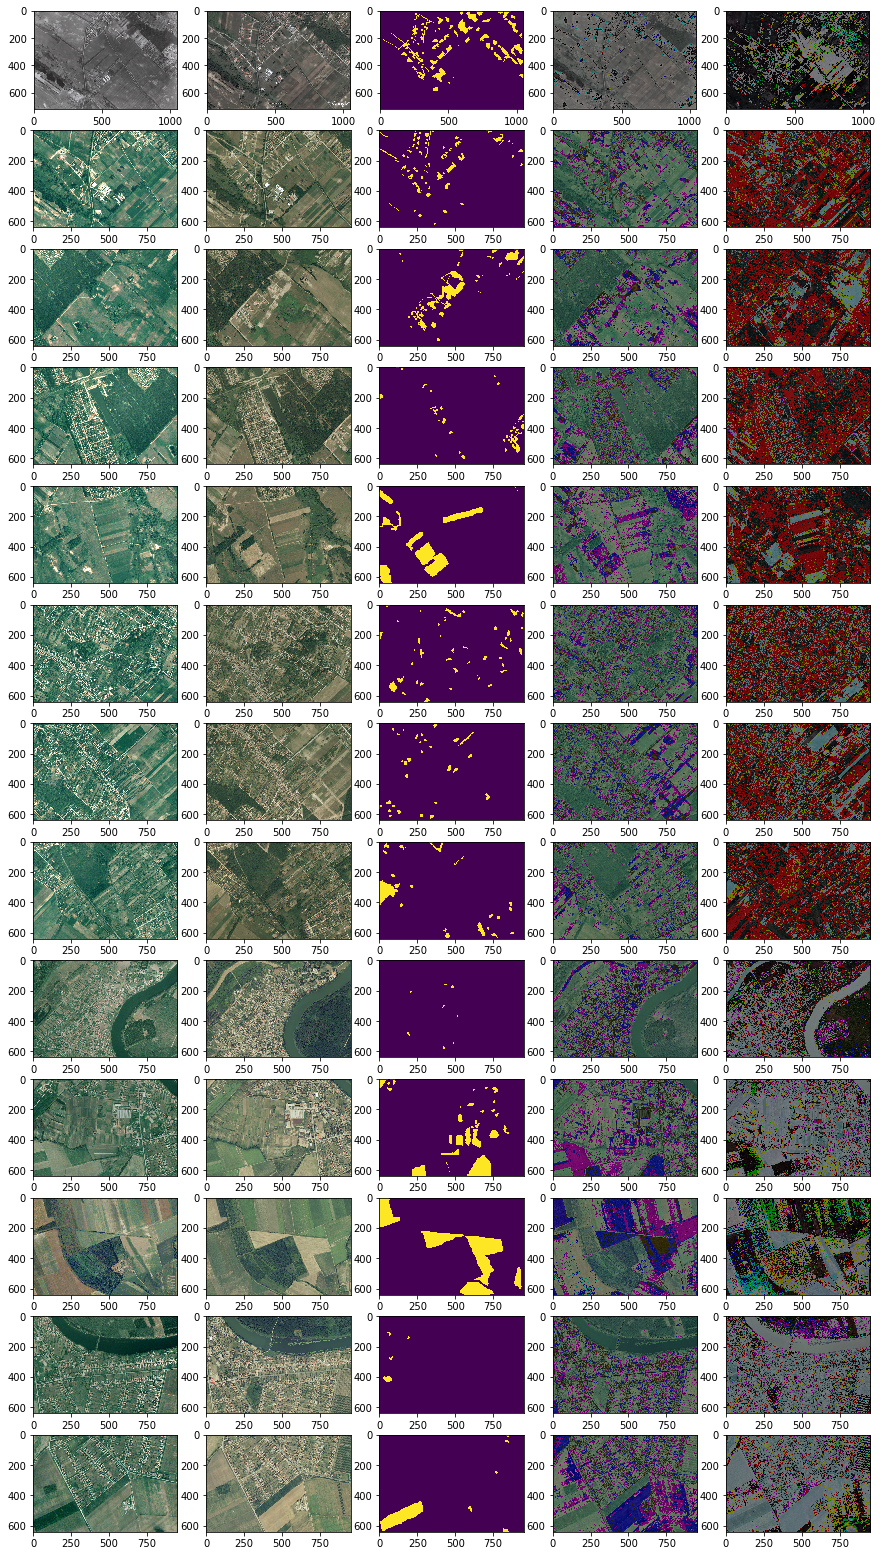

In [84]:
plt.figure(1,figsize=(15,28))
for i in range(13):
    im1 = mpimg.imread(im1s[i])
    im2 = mpimg.imread(im2s[i])
    gt = mpimg.imread(gts[i])
    plt.subplot(13,5,i*5+1)
    plt.imshow(im1)
    plt.subplot(13,5,i*5+2)
    plt.imshow(im2)
    plt.subplot(13,5,i*5+3)
    plt.imshow(gt)
    plt.subplot(13,5,i*5+4)
    plt.imshow((im1+im2)//2)
    plt.subplot(13,5,i*5+5)
    plt.imshow((im1-im2)//2)
plt.show()

## 数据预处理

## 网络搭建

In [96]:
# %load models.py
# 用来存放模型的脚本
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np


class loss(nn.Module):
    def __init__(self):
        super(loss, self).__init__()
        self.m = 5e-4
        
    def forward(self, D, Y):
        loss = 0.0
        m = self.m  # 可能设置为一个可以学习的参数
        D = D.cpu().detach().numpy()
        Y = Y.cpu().detach().numpy()
        w_u = 0.7
        w_c = 0.3
        loss = np.sum(Y*pow(np.maximum(0, m-D), 2)*w_c + (1-Y)*pow(D, 2)*w_u) / 2

        return torch.tensor(loss, requires_grad=True)


class SiameseNet(nn.Module):
    # 卷积过程中feature map大小不变的卷积网络
    def __init__(self):
        super(SiameseNet, self).__init__()
        self.featureExtract = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.Conv2d(64, 64, 5, padding=2),
            nn.Conv2d(64, 32, 5, padding=2),
            nn.Conv2d(32, 16, 1, padding=0),
        )
        self.distance = nn.PairwiseDistance(p=2)

    def forward(self, x1, x2):
        x1 = self.featureExtract(x1)
        x2 = self.featureExtract(x2)
        x = self.distance(x1, x2)

        return x

class Siamese_diff_add(nn.Module):
    # 双通道，一个用来学习相同特征，一个用来学习不同特征
    def __init__(self):
        super(Siamese_diff_add, self).__init__()
        self.add_stage = nn.Sequential(
            nn.Conv2d(3,64,3,padding=1),
            nn.BatchNorm1d(64),
#             nn.MaxPool2d(3,stride=2),
            nn.ReLU() # inplace=True
            
            nn.Conv2d(3,64,3,padding=1),
            nn.BatchNorm1d(64),
#             nn.MaxPool2d(3,stride=2),
            nn.ReLU() # inplace=True
            
            nn.Conv2d(3,64,3,padding=1),
            nn.BatchNorm1d(64),
#             nn.MaxPool2d(3,stride=2),
            nn.ReLU() # inplace=True
            
        )
        
        self.diff_stage = nn.Sequential(
            nn.Conv2d(3,64,3,padding=1),
            nn.BatchNorm1d(64),
#             nn.MaxPool2d(3,stride=2),
            nn.ReLU() # inplace=True
            
            nn.Conv2d(3,64,3,padding=1),
            nn.BatchNorm1d(64),
#             nn.MaxPool2d(3,stride=2),
            nn.ReLU() # inplace=True
            
            nn.Conv2d(3,64,3,padding=1),
            nn.BatchNorm1d(64),
#             nn.MaxPool2d(3,stride=2),
            nn.ReLU() # inplace=True
            
        )

    def forward(self,im1,im2):
        im_add = (im1 + im2) / 2
        im_diff = (im1 - im2) / 2
        
        x_add = self.add_stage(im_add)
        x_diff = self.diff_stage(im_diff)
        
        
        
        return
        

        
        


if __name__ == "__main__":
    net = SiameseNet()
    print(net)
    # print(list(net.parameters()))


SiameseNet(
  (featureExtract): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
  )
  (distance): PairwiseDistance()
)


Object `nn.ReLU` not found.
